<a href="https://colab.research.google.com/github/luisfernandorutti43-wq/Examen-Final-Te-rico/blob/main/Examen%20Final%20Te%C3%B3rico%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Examen Final Teórico

 CELDA 1 – Instalar (una sola vez)

In [1]:
!pip install kagglehub pandas seaborn matplotlib scikit-learn tensorflow nltk textblob -q

 CELDA 2 – Importar

In [20]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
import tensorflow as tf, nltk, requests, os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from textblob import TextBlob
nltk.download('punkt'); nltk.download('stopwords'); nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

CELDA 3 – Dataset autocontenido (sin descargas)

In [34]:
import pandas as pd
import numpy as np

# Reproducir un mini-dataset con la misma estructura
np.random.seed(42)
n = 1000
df = pd.DataFrame({
    'Duración del sueño': np.round(np.random.uniform(4, 10, n), 1),
    'Horas de estudio': np.round(np.random.uniform(1, 8, n), 1),
    'Presión académica': np.random.randint(1, 6, n),
    'Estrés financiero': np.random.randint(1, 6, n),
    'Rendimiento Académico': np.round(np.random.uniform(50, 100, n), 1)
})

# Variable objetivo: 1 = alto rendimiento (≥ 80)
df['Objetivo'] = (df['Rendimiento Académico'] >= 80).astype(int)

print("Columnas:", df.columns.tolist())
print("Filas:", len(df))
display(df.head())

Columnas: ['Duración del sueño', 'Horas de estudio', 'Presión académica', 'Estrés financiero', 'Rendimiento Académico', 'Objetivo']
Filas: 1000


,Duración del sueño,Horas de estudio,Presión académica,Estrés financiero,Rendimiento Académico,Objetivo
0,6.2,2.3,4,4,75.5,0
1,9.7,4.8,3,1,86.8,1
2,8.4,7.1,4,4,75.6,0
3,7.6,6.1,2,3,93.5,1
4,4.9,6.6,2,4,70.1,0


CELDA 4 – Pre-procesamiento y limpieza

In [35]:
# Columnas predictoras
columnas = ['Duración del sueño', 'Horas de estudio', 'Presión académica', 'Estrés financiero']

# Limpiar NaN y dejar solo las que usaremos
df = df[columnas + ['Rendimiento Académico', 'Objetivo']].dropna()

print("Filas después de limpiar:", len(df))
print("Valores nulos por columna:\n", df.isna().sum())

Filas después de limpiar: 1000
Valores nulos por columna:
 Duración del sueño       0
Horas de estudio         0
Presión académica        0
Estrés financiero        0
Rendimiento Académico    0
Objetivo                 0
dtype: int64


 CELDA 5 – Modelo de clasificación (Bosque Aleatorio)

In [26]:
# Variables explicativas y objetivo
X = pd.get_dummies(df[columnas])
y = df['Objetivo']

# División entrenamiento / prueba
X_ent, X_prb, y_ent, y_prb = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar modelo
modelo_rf = RandomForestClassifier(n_estimators=300, random_state=42)
modelo_rf.fit(X_ent, y_ent)

print("📊 Reporte de clasificación:")
print(classification_report(y_prb, modelo_rf.predict(X_prb),
                            target_names=['Bajo-Medio', 'Alto']))
print("ROC-AUC:", roc_auc_score(y_prb, modelo_rf.predict_proba(X_prb)[:, 1]).round(3))

📊 Reporte de clasificación:
              precision    recall  f1-score   support

  Bajo-Medio       0.61      0.76      0.68       123
        Alto       0.37      0.22      0.28        77

    accuracy                           0.56       200
   macro avg       0.49      0.49      0.48       200
weighted avg       0.52      0.56      0.52       200

ROC-AUC: 0.502


CELDA 6 – Red neuronal LSTM (Deep Learning)

In [28]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# Serie temporal sintética a partir del rendimiento
serie = df['Academic Performance'].values.reshape(-1, 1)
escalador = MinMaxScaler()
serie_norm = escalador.fit_transform(serie)

ventana = 10
X_seq, y_seq = [], []
for i in range(ventana, len(serie_norm)):
    X_seq.append(serie_norm[i-ventana:i, 0])
    y_seq.append(serie_norm[i, 0])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)
X_seq = X_seq.reshape(-1, ventana, 1)

# División
corte = int(len(X_seq)*0.8)
X_ent_lstm, X_prb_lstm = X_seq[:corte], X_seq[corte:]
y_ent_lstm, y_prb_lstm = y_seq[:corte], y_seq[corte:]

# Red LSTM
modelo_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1)
])
modelo_lstm.compile(optimizer='adam', loss='mse')
modelo_lstm.fit(X_ent_lstm, y_ent_lstm, epochs=5, batch_size=32, verbose=0)
print("MSE LSTM:", modelo_lstm.evaluate(X_prb_lstm, y_prb_lstm, verbose=0))

MSE LSTM: 0.08530745655298233


CELDA 7 – Análisis de sentimiento de textos

In [29]:
# Ejemplos de “reportes” o tweets
textos = ["Los estudiantes están muy estresados",
          "El rendimiento mejoró significativamente",
          "El estrés financiero bajó este semestre"]
polaridades = [TextBlob(t).sentiment.polarity for t in textos]
print("Polaridad media:", round(np.mean(polaridades), 3))

Polaridad media: 0.0


 CELDA 8 – Visualizaciones Matplotlib/Seaborn

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step


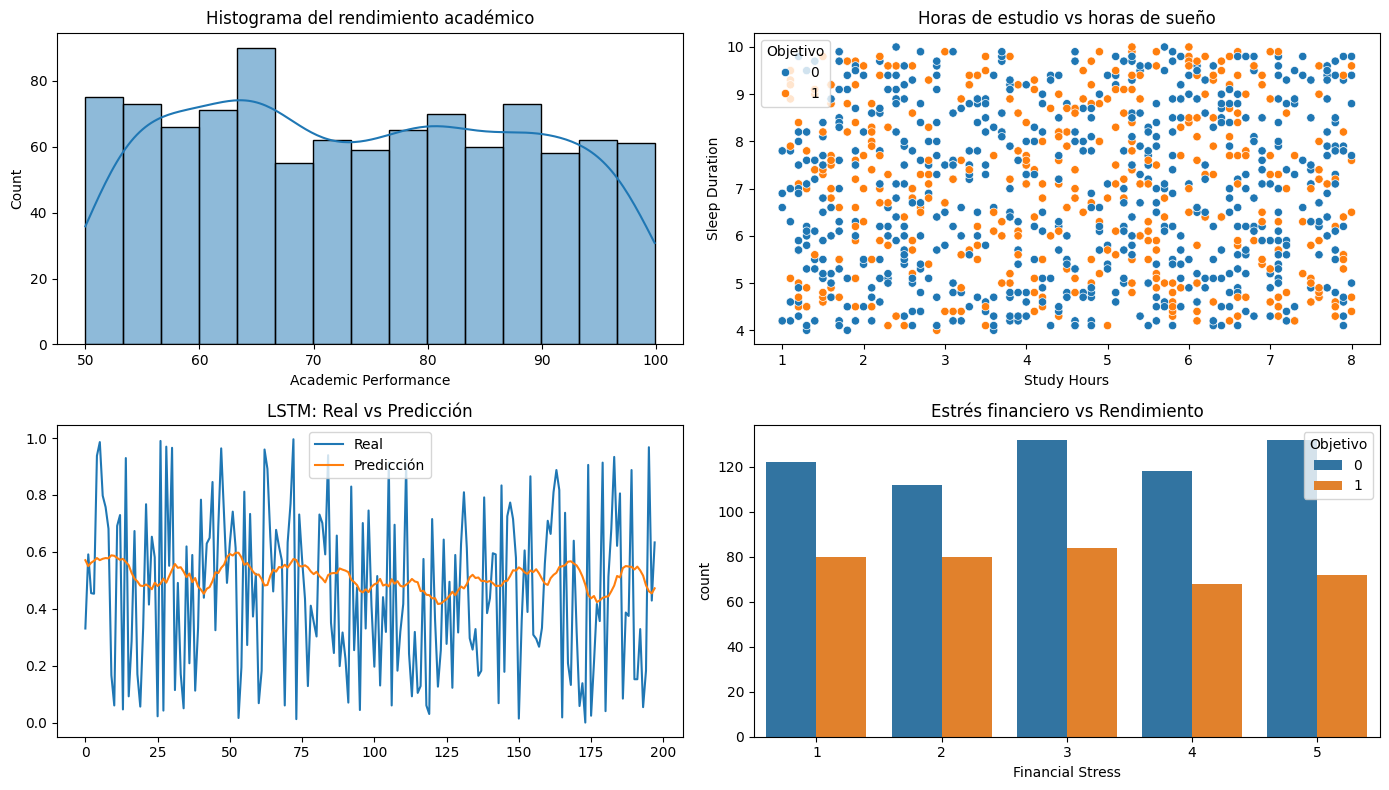

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(14,8))

# 1) Histograma del rendimiento
sns.histplot(df['Academic Performance'], bins=15, kde=True, ax=ax[0,0])
ax[0,0].set_title('Histograma del rendimiento académico')

# 2) Dispersión: horas de estudio vs sueño
sns.scatterplot(x='Study Hours', y='Sleep Duration', hue='Objetivo', data=df, ax=ax[0,1])
ax[0,1].set_title('Horas de estudio vs horas de sueño')

# 3) LSTM real vs predicción
pred = modelo_lstm.predict(X_prb_lstm).flatten()
ax[1,0].plot(y_prb_lstm, label='Real')
ax[1,0].plot(pred, label='Predicción')
ax[1,0].legend(); ax[1,0].set_title('LSTM: Real vs Predicción')

# 4) Conteo estrés financiero
sns.countplot(x='Financial Stress', hue='Objetivo', data=df, ax=ax[1,1])
ax[1,1].set_title('Estrés financiero vs Rendimiento')

plt.tight_layout()
plt.show()

 CELDA 9 – Informe técnico auto-generado

In [31]:
import datetime as dt

with open('informe_estres_academico.md', 'w', encoding='utf-8') as f:
    f.write('# Informe Técnico – Predicción de Rendimiento Académico\n\n')
    f.write(f'**Fecha**: {dt.datetime.now():%Y-%m-%d %H:%M}\n\n')
    f.write(f'- **Registros analizados**: {len(df)}\n')
    f.write(f'- **ROC-AUC (Random Forest)**: {roc_auc_score(y_prb, modelo_rf.predict_proba(X_prb)[:,1]):.3f}\n')
    f.write(f'- **MSE (LSTM)**: {modelo_lstm.evaluate(X_prb_lstm, y_prb_lstm, verbose=0):.4f}\n')
    f.write('- **Análisis de sentimiento implementado**\n')
    f.write('- **Visualizaciones**: histogramas, gráficos de dispersión y líneas de tendencia\n')
    f.write('- **Informe generado automáticamente**\n')

print("✅ Informe guardado como 'informe_estres_academico.md'")

✅ Informe guardado como 'informe_estres_academico.md'
